# Aplicação 1: Varredura em frequência de um filtro passa-baixa 

Conecte um capacitor de $0.22\, \mu C$ e um resistor de $150\, \Omega$ na configuração de filtro passa-baixa. Ligue o canal 1 do gerador de função no canal 1 do osciloscópio e conecte o canal 2 do osciloscópio entre o resistor e o gerador de funções. Também conecte a saída SYNC do gerador de funções na entrada EXT do osciloscópio

In [2]:
## parametros de varredura
PATH = '/home/luan/projects/labs-f/labs-f/F540/exp1/files'     # pasta onde salvar todos os arquivos
## Não coloque .dat aqui, pois as extensões são adicionadas automaticamente
nome_arquivo = 'exp1'    # nome prefixo dos arquivos  
output_curvas = True      # condicional para imprimir as curvas e os dados da tela do osciloscópio     
Vpp = 2.0      # Tensão pico-a-pico na saida do gerador
Nfreq = 20     # frequências número de pontos
freq0 = 100    # frequências inicial
freq1 = 300e3  # frequências final

In [10]:
### importa as bibliotecas necessárias
import pylef   # importar pylef 
import visa    # importar a bilioteca pyVISA para lidar com virtualização de instrumentos
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os            # biblioteca para lidar com diretórios
# próxima linha faz plotar o gráfico dentro do notebook
%matplotlib inline   

In [12]:
# imprime os recursos para ter certeza que os instrumentos estão conectados
visa.ResourceManager().list_resources()

OSError: Could not open VISA library:


In [4]:
func_gen = pylef.BK4052()          # definição do gerador de funções
scope = pylef.TektronixTBS1062()   # definição do osciloscópio

Gerador de Funções conectado! Id = *IDN BK Precision,SDG1010,389K15133
Osciloscópio conectado! Id = TEKTRONIX,TBS 1062,C010162,CF:91.1CT FV:v26.01


In [5]:
## Cria o diretório
try: 
    os.makedirs(PATH)     # make new directory unless it already exists
except OSError:
    if not os.path.isdir(PATH):
        raise

In [6]:
##### Pré-aquisição
# mude a onda para uma senóide! O que acontece se usarmos a onda triângular?
func_gen.ch1.set_function('sine')
## ajuste o trigger externo
func_gen.ch1.sync_on()   # ligar o sync reference ao canal 1
scope.trigger.set_source('ext')  # ajusta o trigger para externo no osciloscópio
## ajusta média nos canais
scope.set_average_number(4)  # ajusta o número de médias
scope.set_average()    # turn average ON
#scope.set_sample()       # turn average OFF
## parâmetros inicias do gerador
func_gen.ch1.set_frequency(freq0) 
func_gen.ch1.set_Vpp(Vpp)
func_gen.ch1.set_offset(0.0)
func_gen.ch1.set_phase(0.0)
## tenha certeza que o gerador está ligado e que o canal 1 está na escala certa
func_gen.ch1.turn_on()   # liga o canal 1
scope.set_horizontal_scale((1/freq0)/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
scope.ch1.set_smart_scale()  # rescala o canal 1
scope.ch2.set_smart_scale()  # rescala o canal 2

In [7]:
#### Aquisição de dados!! ####
freq = np.logspace(np.log10(freq0), np.log10(freq1), Nfreq, endpoint = True)  # varredura logaritmica
Vpp1, Vpp2 = [], []    # listas para guardar as variáveis
phase1, phase2 = [], []    # listas para guardar as variáveis
### aquisição de dados no gerador com varredura de frequência
scope.write('MEASUREment:MEAS1:TYPE NONE')
scope.write('MEASUREment:MEAS2:TYPE NONE')
scope.write('MEASUREment:MEAS3:TYPE NONE')
scope.write('MEASUREment:MEAS4:TYPE NONE')
scope.write('MEASUREment:MEAS5:TYPE NONE')
for m, freqP in enumerate(list(freq)):  # loop de aquisição
    ### ajuste dos instrumentos
    func_gen.ch1.set_frequency(freqP)   # muda a frequência
    periodP = 1./freqP   # período da onda
    scope.set_horizontal_scale(periodP/4.)  # escala horizontal = 1/4 período (2.5 oscilações em tela)
    time.sleep(0.05)   # espere 50 microssegundos
    scope.ch2.set_smart_scale()    #  rescala o canal 2
    ### aquisição de dados
    Vpp1.append(scope.ch1.measure.Vpp()) # acumula a medida do Vpp no canal 1
    phase1.append(scope.ch1.measure.phase()) # acumula a medida da fase no canal 1    
    time.sleep(0.05)  # wait between the data acquisition
    Vpp2.append(scope.ch2.measure.Vpp())  # acumula a medida do Vpp no canal 2
    phase2.append(scope.ch2.measure.phase()) # acumula a medida da fase no canal 2
    if output_curvas:
        num = np.floor(-np.log10(periodP)/3.) + 1 # referência para a escala do gráfico
        ### leitura dos traços temporais
        (t1, V1) = scope.ch1.read_channel()  # mede o canal 1
        (t2, V2) = scope.ch2.read_channel()  # mede o canal 2
        ### produção das figuras
        fig = plt.figure()  # definição da figura
        ax = fig.add_subplot(111)  # definição do eixo
        ax.plot(t1*10**(3*num), V1, label = 'Vin')       # plota canal 1
        ax.plot(t2*10**(3*num), V2, label = 'Vout')      # plota canal 2
        plt.axis([None, None, -1.1*Vpp/2, 1.1*Vpp/2])    # ajusta os máximos e mínimos dos gráficos
        ax.set_ylabel('Tensões (V)')
        ax.legend()   # imprime as legendas no gráfico
        if num == 0.0: ax.set_xlabel('Tempo (s)')    
        if num == 1.0: ax.set_xlabel('Tempo (ms)')
        if num == 2.0: ax.set_xlabel('Tempo (us)')
        ### salva em arquivo os dados da aquisição
        file_sweep_name = nome_arquivo + str(m + 1) + '_curvas'   # nome dos arquivos de sweep
        time_suf = time.strftime('_%H_%M_%S', time.localtime(time.time())) 
        fig.savefig(PATH + file_sweep_name + time_suf + '.png', bbox_inches = 'tight')   #
        scope.save_channels(file_sweep_name, PATH = PATH)
#        plt.show()         # impressão na tela! 
        fig.clear()
    print('terminada a frequência %4.3f kHz' % (1e-3*freqP))
    print('Medida ' + str(m + 1) + '\n')
#    print('tempo de medida = ' + time.strftime('%H h %M min %S seg', time.localtime(time.time())))   
Vpp1 = np.array(Vpp1)  # convete a lista em array
Vpp2 = np.array(Vpp2)  # convete a lista em array
phase1 = np.array(phase1)  # convete a lista em array
phase2 = np.array(phase2)  # convete a lista em array

... file => exp 11_curvas_19_19_51 saved!!
terminada a frequência 0.100 kHz
Medida 1

... file => exp 12_curvas_19_20_02 saved!!
terminada a frequência 0.740 kHz
Medida 2

... file => exp 13_curvas_19_20_14 saved!!
terminada a frequência 5.477 kHz
Medida 3

... file => exp 14_curvas_19_20_25 saved!!
terminada a frequência 40.536 kHz
Medida 4

... file => exp 15_curvas_19_20_36 saved!!
terminada a frequência 300.000 kHz
Medida 5



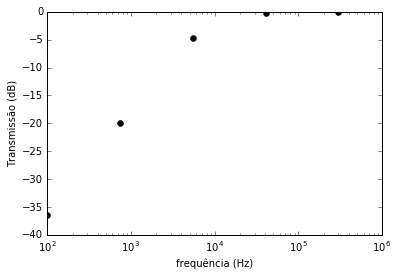

In [8]:
## Análise de dados (não mude a variável PATH)
T = Vpp2/Vpp1   # cálculo da transmissão 
T_dB = 20*np.log10(T)  # transmissão em dB
dados = pd.DataFrame()   # inicializa um dataframe do pandas
dados['Vpp1 (V)'], dados['Vpp2 (V)'] = Vpp1, Vpp2
dados['fase1 (rad)'], dados['fase2 (rad)'] = Vpp1, Vpp2
dados['frequencia (Hz)'], dados['T'] , dados['T_dB'] = freq, T, T_dB 
# plota o diagrama de bode para a transmissão e exporta em png
fig = plt.figure()   # define uma figura
ax = fig.add_subplot(111)  # define um eixo
ax.plot(freq, T_dB, 'ko')   # plota a transmissão  
ax.set_xscale('log')   # seta a escala de x para logaritmica
# Por que não usamos escala log no eixo y também?
ax.set_xlabel('frequência (Hz)')   # seta escala do eixo x
ax.set_ylabel('Transmissão (dB)')   # seta escala do eixo y
time_suf = time.strftime('_%H_%M_%S', time.localtime(time.time())) 
fig.savefig(PATH + nome_arquivo + '_bode' + time_suf + '.png', bbox_inches = 'tight')  # salva figura na pasta de trabalho
dados.to_csv(PATH + nome_arquivo + '_dados' + time_suf + '.dat', sep = '\t')   # \t significa que o separador é uma tabulação
plt.show()

In [9]:
## fecha o osciloscópio e o gerador de funções
scope.close()
func_gen.close()